# [E-01]RockPaperScissor (가위바위보 분류기 만들기)
## 목차
##### 01. 데이터 준비
##### 02. 딥러닝 네트워크 설계
##### 03. 딥러닝 네트워크 학습
##### 04. 테스트(평가)
##### 05. 정확도
##### 06. 참조
##### 07. 회고
##### 

## 01. 데이터 준비
- Google의 'teachable machine' 사이트를 통해 이미지 데이터 생성
- 디렉토리 'rock_scissor_paper' 및 하위 디렉토리 생성, 가위 바위 보 데이터셋 준비

In [599]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt

In [600]:
from PIL import Image
import os, glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


- PIL 라이브러리를 설치하는 이유는 '가위,바위,보'이미지의 사이즈를 224x224에서 28x28로 변경하기 위해

In [601]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

- 파일마다 모두 28x28 사이즈로 바꾸어 target_size에 저장

In [602]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

400  images to be resized.
400  images resized.
가위 이미지 resize 완료!


In [603]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
    
print("바위 이미지 resize 완료!")

400  images to be resized.
400  images resized.
바위 이미지 resize 완료!


In [604]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

400  images to be resized.
400  images resized.
보 이미지 resize 완료!


- resize 메서드를 활용하여 가위, 바위, 보 모두 28x28 사이즈로 resize 완료

In [605]:
def load_data(img_path, number_of_data=1200):  
  
    img_size=28
    color=3

    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=1  
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   
        labels[idx]=2  
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1200 입니다.
x_train shape: (1200, 28, 28, 3)
y_train shape: (1200,)


- load_data() 함수를 통해 이미지가 있는 폴더의 데이터를 부름
- 학습데이터의 이미지 개수는 총 1200개
- 이미지 데이터와 라벨데이터를 담은 행렬 영역을 생성하여 라벨링 (가위:0, 바위:1, 보:2)
- 데이터는 각 픽셀 값의 0~255 범위에 있으므로, 데이터들을 255.0으로 나누어 입력은 0 ~ 1 사이의 값으로 정규화시킴

라벨:  0


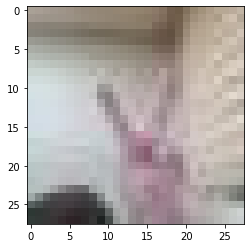

In [606]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

- 데이터셋의 X항목(x_train)은 이미지를 담은 행렬
- 데이터셋의 Y항목(y_train)은 실제 숫자를 담은 행렬

## 02. 딥러닝 네트워크 설계

In [607]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))     
model.add(keras.layers.Dense(3, activation='softmax'))   

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


- tf.keras의 Sequential API를 이용
- Conv2D의 사이즈가 3x3인 필터를 32개, 64개 사용하여 이미지의 특징을 다양화 
- 이미지의 색상이 컬러이므로, input_shape=(28,28,3)으로 지정
- 복잡한 영상임으로 인지하고 dense의 뉴런 숫자 32를 지정
- 최종 분류기의 Class가 가위,바위,보 3종류이므로 3을 기입 

- Conv2D는 필터로 특징을 뽑아 주는 Convolution 레이어
- MaxPool2D 와 MaxPooling2D 는 이름만 크게 다를 뿐, 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듬
- Flatten는 전결합층에 전달하기 위해 1차원 자료로 바꾸어 주는 레이어
- Dense 레이어의 첫 번째 인자는 분류기에 사용되는 뉴런 숫자, 마지막 Dense 레이어의 뉴런 숫자는 결과적으로 분류해내야하는 수


In [608]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                51232     
_________________________________________________________________
dense_89 (Dense)             (None, 3)               

## 03. 딥러닝 네트워크 학습

In [609]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=20)

Epoch 1/20
38/38 [==============================] - 0s 3ms/step - loss: 1.0062 - accuracy: 0.5083
Epoch 2/20
38/38 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.7717
Epoch 3/20
38/38 [==============================] - 0s 3ms/step - loss: 0.2773 - accuracy: 0.9508
Epoch 4/20
38/38 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.9817
Epoch 5/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0541 - accuracy: 0.9967
Epoch 6/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9967
Epoch 7/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 8/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 1.0000
Epoch 9/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 10/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 11/20
38/38 [

- 'epochs = 20' : 전체 데이터를 20번 반복 사용하여 학습

## 04. 테스트(평가)    

In [610]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor_test"
resize_images(image_dir_path)

print("가위_test 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock_test"
resize_images(image_dir_path)

print("바위_test 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper_test"
resize_images(image_dir_path)

print("보_test 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위_test 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위_test 이미지 resize 완료!
100  images to be resized.
100  images resized.
보_test 이미지 resize 완료!


- 위와 동일하게 resize 메서드를 활용하여 가위_test, 바위_test, 보_test 모두 28x28 사이즈로 resize 완료

In [611]:
def load_data_test(img_path, number_of_data=300):  
  
    img_size=28
    color=3

    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=1  
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   
        labels[idx]=2  
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data_test(image_dir_path)
x_test_norm = x_test/255.0   

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [612]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.6679 - accuracy: 0.7233
test_loss: 1.6679376363754272 
test_accuracy: 0.7233333587646484


## 5. 정확도
- 학습 데이터 300장, 테스트 데이터 300장, Epoch==10, accuracy: 0.1200
- 학습 데이터 600장, 테스트 데이터 300장, Epoch==10, accuracy: 0.3333
- 학습 데이터 600장, 테스트 데이터 300장, Epoch==30, accuracy: 0.4067
- 학습 데이터 1200장, 테스트 데이터 300장, Epoch==10, accuracy: 0.3067
- 학습 데이터 1200장, 테스트 데이터 300장, Epoch==30, accuracy: 0.3100
- 학습 데이터 2400장, 테스트 데이터 300장, Epoch==10, accuracy: 0.3899
- 학습 데이터 2400장, 테스트 데이터 300장, Epoch==30, accuracy: 0.4133 
- 학습 데이터 2400장, 테스트 데이터 300장, Epoch==30, accuracy: 0.4800 (Conv2D 필터의 개수 조정 각각 32,64 -> 64,128)
- 학습 데이터 2400장, 테스트 데이터 300장, Epoch==30, accuracy: 0.5867 (dense: 32 -> 64)
> 목표한 정확도(60%)에 가까워졌기에 테스트 데이터의 이미지를 수정할 필요를 느낌.  테스트 데이터의 사진을 다른 데이터로 변경해보고, 개수도 조정해봄

- 학습 데이터 2400장, 테스트 데이터 240장, Epoch==30, accuracy: 0.3833 
- 학습 데이터 2400장, 테스트 데이터 240장, Epoch==30, accuracy: 0.3958 (Conv2D 필터의 개수 다시 조정 각각 64,128 ->128,256)
> 기존의 학습 데이터에서 질이 좋지 않은 이미지를 300장 제거해봄
 
- 학습 데이터 2100장, 테스트 데이터 240장, Epoch==30, accuracy: 0.4000
> 여기서 학습 데이터량만 높이면 된다고 판단함

- 학습 데이터 3300장, 테스트 데이터 300장, Epoch==30, accuracy: 0.2000
> 무작정 학습 데이터량만 늘렸을 뿐인데 정확도는 오히려 낮아졌기에 학습데이터의 질을 높여 좋은 데이터만으로 학습을 다시 시작했음

Conv 24D 필터 각각: 32,64 / dense:32로 model 값은 건들지 않고 학습량만 생각을 해보겠다는 판단을 함
- 학습 데이터 600장, 테스트 데이터 300장, Epoch==20, accuracy: 0.5067
- 학습 데이터 1200장, 테스트 데이터 300장, Epoch==20, accuracy: 0.7233
> 목표하던 정확도 이상의 결과를 보였음.

## 정확도 = 72%

## 6. 참조
#### 각 레이어의 명칭과 쓰임을 참조하였음 : https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/

## 7. 회고
#### - 처음 진행하던 프로젝트 이기도 했고, 아직까지 파이썬과 각종 용어에 대한 지식이 미숙한 편이었기에 코드 작성에 조금 까다로움을 느꼈던 것 같다. 코드에 대한 내용의 큰 틀은 파악했으나, 아직 명칭과 쓰임에 대해서 미숙하여 전반적인 내용 학습이 더 필요하다 느꼈다.

#### - 일단 결과물에 대해서는 스스로 만족하는 것 같다. 처음에 학습 데이터 300개와 테스트 데이터 300개의(비율 1:1) 이미지를 가지고 정확도 판단을 시작했다. 그러면서 학습데이터만 점차 2배씩 늘려갔고 중간에 하이퍼파라미터를 과도하게 조절하기도 했다. 원하는 정확도에 거의 도달했을 쯤에 테스트데이터의 이미지 질이 좋지 않다고 판단하여 새롭게 변경하고 개수도 조정했다. 그러고나서 학습 데이터를 늘리니 오히려 오버피팅의 결과를 일으켰다. 원인을 찾지 못해 하이퍼파라미터를 계속 조절해도 정확도는 쉽게 오르지 않았다. 그래서 내린 생각은 적절한 하이퍼파라미터 값을 정해놓고, 질이 좋은 학습데이터만을 구성하여 다시 학습량을 점차 늘려가자는 것이 결론이었다. 그랬더니 결국 목표하던 정확도 이상의 결과값을 얻어낼 수 있었다.

